# 🧠 Rock Paper Scissors Classification with MobileNetV2 (Fixed Version)

## 1. Install and Import Libraries

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from datasets import load_dataset
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


c:\Users\shailshree\Desktop\Academics\3rd year\computervision\coursework\app\rock_paper_scissor_game_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Extract Dataset from Hugging Face

In [ ]:

dataset = load_dataset("Javtor/rock-paper-scissors")
label_names = dataset['train'].features['label'].names

base_dir = "dataset"
splits = ['train', 'test']

def save_images_to_folder(split_name):
    split_dataset = dataset[split_name]
    for idx, sample in enumerate(split_dataset):
        label = label_names[sample['label']]
        image = sample['image']
        if image.mode == 'RGBA':
            image = image.convert('RGB')
        save_dir = os.path.join(base_dir, split_name, label)
        os.makedirs(save_dir, exist_ok=True)
        image_path = os.path.join(save_dir, f"{split_name}_{label}_{idx}.jpg")
        image.save(image_path)

for split in splits:
    save_images_to_folder(split)


## 3. Load Dataset and Extract Correct Class Order

In [2]:

train_dir = 'dataset/train'
test_dir = 'dataset/test'

# Load class names in correct order
temp_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=1)
class_indices = temp_gen.class_indices
class_names = [None] * len(class_indices)
for name, index in class_indices.items():
    class_names[index] = name

print("✅ Class order:", class_names)

with open("class_names.json", "w") as f:
    json.dump(class_names, f)


Found 2520 images belonging to 3 classes.
✅ Class order: ['paper', 'rock', 'scissors']


## 4. Create Augmented Data Generators

In [3]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.7, 1.3],
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32,
    class_mode='categorical', subset='training'
)
val_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32,
    class_mode='categorical', subset='validation'
)
test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)


Found 2016 images belonging to 3 classes.
Found 504 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


## 5. Compute Class Weights

In [4]:

y_train = train_gen.classes
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))


## 6. Define Model Architecture

In [5]:

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


## 7. Train Top Layers

In [6]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)
]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_gen, validation_data=val_gen,
                    epochs=10, class_weight=class_weights, callbacks=callbacks)


c:\Users\shailshree\Desktop\Academics\3rd year\computervision\coursework\app\rock_paper_scissor_game_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.6636 - loss: 0.7497

63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 749ms/step - accuracy: 0.6659 - loss: 0.7450 - val_accuracy: 0.9147 - val_loss: 0.2280 - learning_rate: 0.0010
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.9520 - loss: 0.1361

63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 703ms/step - accuracy: 0.9521 - loss: 0.1357 - val_accuracy: 0.9266 - val_loss: 0.2095 - learning_rate: 0.0010
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 695ms/step - accuracy: 0.9636 - loss: 0.1051 - val_accuracy: 0.8472 - val_loss: 0.6622 - learning_rate: 0.0010
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.9713 - loss: 0.0810

63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 704ms/step - accuracy: 0.9714 - loss: 0.0808 - val_accuracy: 0.9504 - val_loss: 0.1386 - learning_rate: 5.0000e-04
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 697ms/step - accuracy: 0.9738 - loss: 0.0611 - val_accuracy: 0.8948 - val_loss: 0.3984 - learning_rate: 5.0000e-04
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 700ms/step - accuracy: 0.9832 - loss: 0.0523 - val_accuracy: 0.9226 - val_loss: 0.2865 - learning_rate: 2.5000e-04


## 8. Fine-Tune Last 20 Layers

In [7]:

base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(train_gen, validation_data=val_gen,
                              epochs=5, class_weight=class_weights, callbacks=callbacks)


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 786ms/step - accuracy: 0.8922 - loss: 0.2931 - val_accuracy: 0.9306 - val_loss: 0.2329 - learning_rate: 1.0000e-05
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 765ms/step - accuracy: 0.9569 - loss: 0.1166 - val_accuracy: 0.9087 - val_loss: 0.3698 - learning_rate: 1.0000e-05
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 763ms/step - accuracy: 0.9660 - loss: 0.0855 - val_accuracy: 0.9325 - val_loss: 0.3167 - learning_rate: 5.0000e-06


## 9. Plot Training & Validation Performance

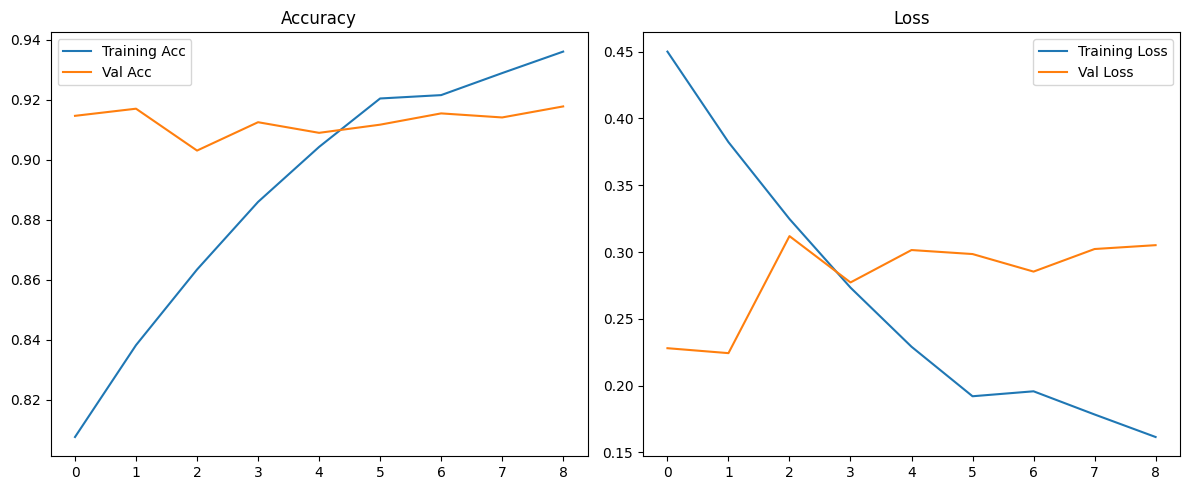

In [8]:

def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def combine_history(h1, h2):
    combined = {}
    for k in h1.history:
        combined[k] = h1.history[k] + h2.history.get(k, [])
    return combined

full_history = combine_history(history, fine_tune_history)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(smooth_curve(full_history['accuracy']), label='Training Acc')
plt.plot(smooth_curve(full_history['val_accuracy']), label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(smooth_curve(full_history['loss']), label='Training Loss')
plt.plot(smooth_curve(full_history['val_loss']), label='Val Loss')
plt.legend()
plt.title('Loss')
plt.tight_layout()
plt.show()


## 10. Export Model

In [9]:

model.save("rock_paper_scissors_model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("rock_paper_scissors_model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\SHAILS~1\AppData\Local\Temp\tmp540wrk1s\assets


INFO:tensorflow:Assets written to: C:\Users\SHAILS~1\AppData\Local\Temp\tmp540wrk1s\assets


Saved artifact at 'C:\Users\SHAILS~1\AppData\Local\Temp\tmp540wrk1s'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  3070088939088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3070088939664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3070088941392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3070088941008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3070088939856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3070088941584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3070088940624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3070088939280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3070088941776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3070088938896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  30